# **MachineRay2** - Image Generation
By Robert. A Gonsalves

Bug Fixes/Extensions:
* 18 Apr 2022 Jon Chun

![MachineRay Output](https://raw.githubusercontent.com/robgon-art/MachineRay2/main/sample%202%20wide.jpg)

This is a project that uses AI to create abstract art.

I gathered images of abstract paintings from WikiArt.org, processed them, and fed them into StyleGAN2 ADA at the size of 1024x1024.
I trained the GAN for four days on a GPU using Google Colab.
I then processed the output images by adjusting the aspect ratio and running them through another ANN for a super-resolution resize.
The resultant images are 4096 pixels wide or tall, depending on the aspect ratio.

This Google Colaboratory allows you to generate unique abstract art automatically.

The source code and generated images are released under the [CC BY-NC-SA license](https://creativecommons.org/licenses/by-nc-sa/4.0/).</br>
![CC BY-NC-SA](https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png)

In [1]:
!nvidia-smi

Mon Apr 18 16:26:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **[ONCE] Initalize the System**
Hit the Run Cell (play) button to intialize the system.

In [2]:
# %tensorflow_version 1.x
!git clone https://github.com/NVlabs/stylegan2-ada
!wget -O "network-snapshot-000188.pkl" "https://www.dropbox.com/s/ya3swqh2t165nkn/network-snapshot-000188.pkl?dl=0"
!wget -O painting_info.txt "https://www.dropbox.com/s/h2bktown2oq2avq/painting_info.txt?dl=0"
# inited_ISR = False

Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), done.
--2022-04-18 16:27:04--  https://www.dropbox.com/s/ya3swqh2t165nkn/network-snapshot-000188.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ya3swqh2t165nkn/network-snapshot-000188.pkl [following]
--2022-04-18 16:27:04--  https://www.dropbox.com/s/raw/ya3swqh2t165nkn/network-snapshot-000188.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc7fcc871cdfc4c72dcd878ff59.dl.dropboxusercontent.com/cd/0/inline/BjrnjirK_y3Z6ZFkwcGstlBq5RVnQZ17x2fPHb9Ta42HtdWxuOhilKklBSdt3r3Rznpe7UT0iOgaiLp5GwqIw5C96CRWQRN-jHIWC8x0JY37tVsVplv72R_QWO_riSYfOJBRyk88eY

In [3]:
# Fix bug: AttributeError: 'str' object has no attribute 'decode'
# wrong version of h5py: (h5py.__version__)

!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 9.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


# **[EACH RUN] Initalize the System**

Select [RUNTIME]>[RESET RUNTIME] and run this for a new iteration

In [1]:
import os
from PIL import Image, ImageOps, ImageFont, ImageDraw
import numpy as np
import random
from datetime import datetime

%matplotlib inline

inited_ISR = False

# **Generate a Sample of Paintings and Show Thumbnails**
Hit the Run Cell button to generate 21 thumbnail images using MachineRay.

In [16]:
# [Re-run] this cell a different number of times to create new art
#   based on different random seeds

seed = random.randint(0,100000)
seed_arg = "--seeds="

for i in range(20):
  seed_arg += str(seed+i) + ","
seed_arg += str(seed+20)

seed_arg

'--seeds=34399,34400,34401,34402,34403,34404,34405,34406,34407,34408,34409,34410,34411,34412,34413,34414,34415,34416,34417,34418,34419'

In [17]:
%%time

# NOTE: 1m00s  @10:00 on 20220418 Colab Pro T4
#       1m13s  @12:29 on 20220418 COlab Pro P100/16GB

%tensorflow_version 1.x

# Clear out the results folder if it exists
if os.path.exists("results"):
  !rm -r results

# Pick a number, any number
seed = random.randint(0,100000)
seed_arg = "--seeds="

for i in range(20):
  seed_arg += str(seed+i) + ","
seed_arg += str(seed+20)

# Generate the images
!python stylegan2-ada/generate.py $seed_arg --trunc=1.4  \
  --outdir results --network=network-snapshot-000188.pkl

# Initialize the x and y arrays
x = np.linspace(0, 849, 850)
y = np.empty(shape=(850))

# Read the file containing the paintings and aspect ratios
info_file = open('painting_info.txt', 'r') 
lines = info_file.readlines()

# Use this font
fnt = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', 20)

# Loop through the lines, capturing the aspect ratio in the y array
count = 0
for line in lines: 
  parts = line.split(' ')
  if len(parts) == 2 and len(parts[1]) > 0:
    y[count] = parts[1]
  count += 1

# Sort the values
y = np.sort(y)

# Use piecewise linear interpolation
def get_aspect_ratio():
  input_x = np.random.rand(1)*850
  y_interp = np.interp(input_x, x, y)
  return y_interp[0]

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# Get all the image file names
image_files = []
for root, dirs, files in os.walk("results"):
    files.sort()
    for file in files:
        if file.endswith(".png"):
             image_files.append(os.path.join(root, file))

# Generate a grid of thumbnails
aspect_ratios = []
size = 250
count = 0
for j in range(0, 3):
  for i in range(0, 7):
    tile = Image.open(image_files[count])
    aspect = get_aspect_ratio()
    aspect_ratios.append(aspect)

    if aspect<1:
      newsize = (int(size * aspect), size)
    else:
      newsize = (size, int(size / aspect))

    tile = tile.resize(newsize)

    delta_w = size - newsize[0] + 20
    delta_h = size - newsize[1] + 30
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    tile = ImageOps.expand(tile, padding, fill = (255, 255, 255))

    draw = ImageDraw.Draw(tile)
    draw.text((0, 0), str(count+1), font=fnt, fill=(0,0,0))

    if i%7 == 0:
      row = tile
    else:
      row = get_concat_h(row, tile)

    count += 1
  
  if j%4 == 0:
    group = row
  else:
    group = get_concat_v(group, row)

# Show the thumbnails
group

TensorFlow 1.x selected.
Loading networks from "network-snapshot-000188.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.
Generating image for seed 84301 (0/21) ...
Generating image for seed 84302 (1/21) ...
Generating image for seed 84303 (2/21) ...
Generating image for seed 84304 (3/21) ...
Generating image for seed 84305 (4/21) ...
Generating image for seed 84306 (5/21) ...
Generating image for seed 84307 (6/21) ...
Generating image for seed 84308 (7/21) ...
Generating image for seed 84309 (8/21) ...
Generating image for seed 84310 (9/21) ...
Generating image for seed 84311 (10/21) ...
Generating image for seed 84312 (11/21) ...
Generating image for seed 84313 (12/21) ...
Generating image for seed 84314 (13/21) ...
Generating image for seed 84315 (14/21) ...
Generating image for seed 84316 (15/21) ...
Generating image for seed 84317 (16/21) ...
Generating image for seed 84318 (17/21) ...
Generati

In [ ]:
# Show the thumbnails

# NOTE: 1m01s @10:01 on 20220418 Colab GPU T4

%matplotlib inline
group

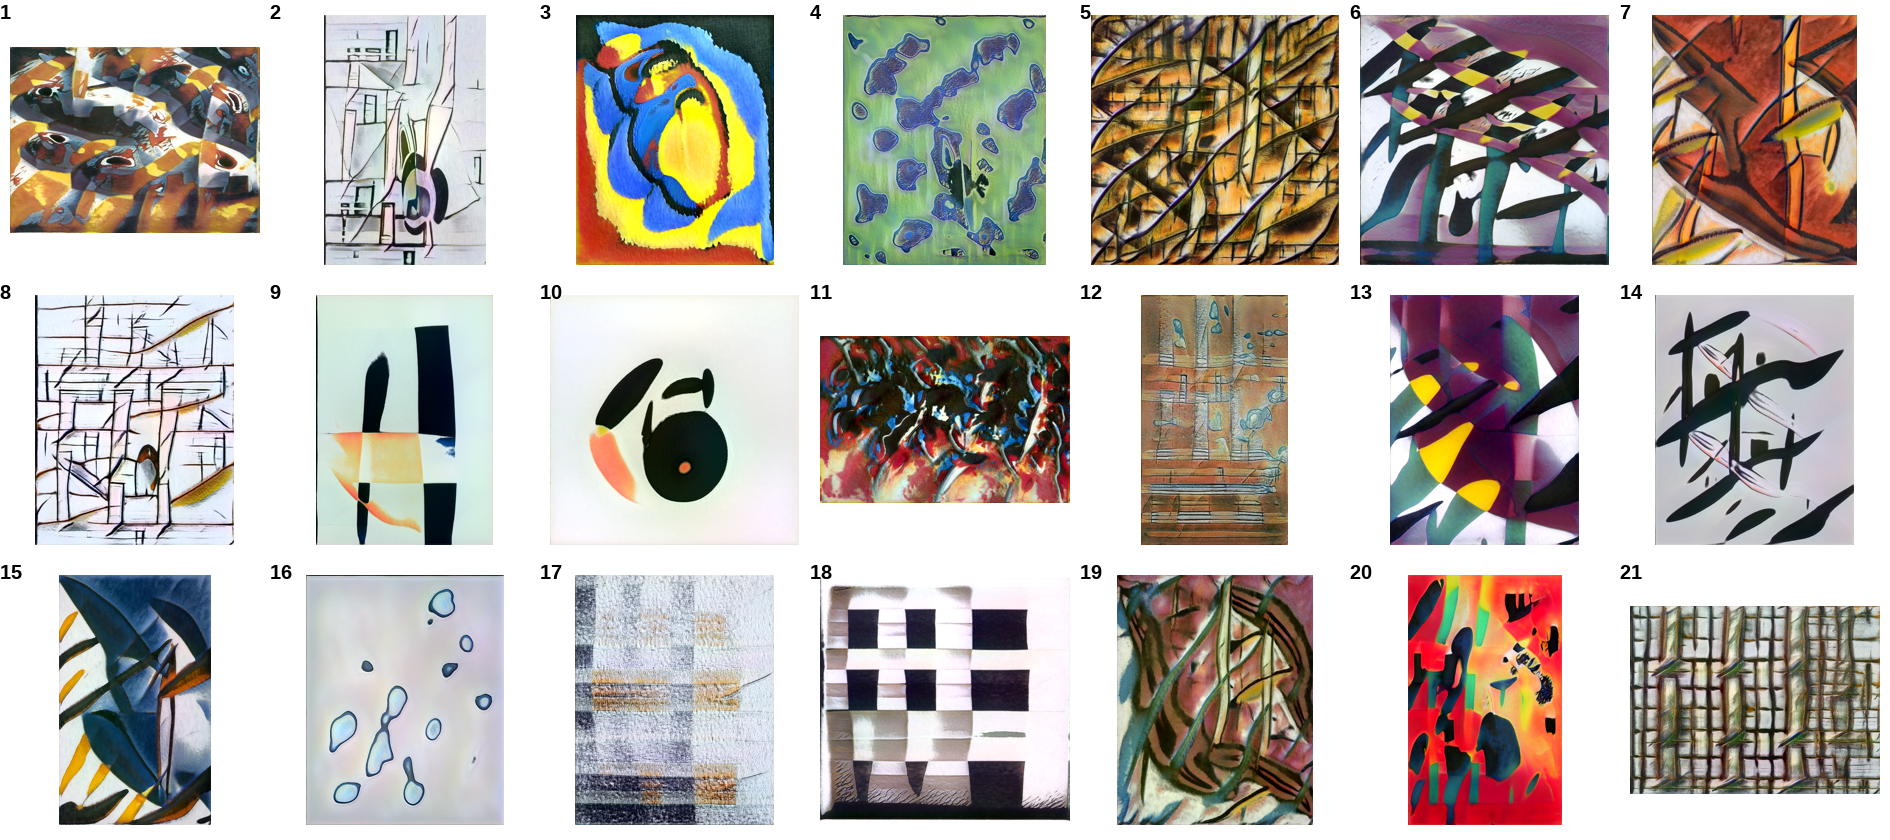

In [18]:
"""
# Show the thumbnails

# NOTE: 1m01s @10:01 on 20220418 Colab GPU T4

%matplotlib inline
group
"""

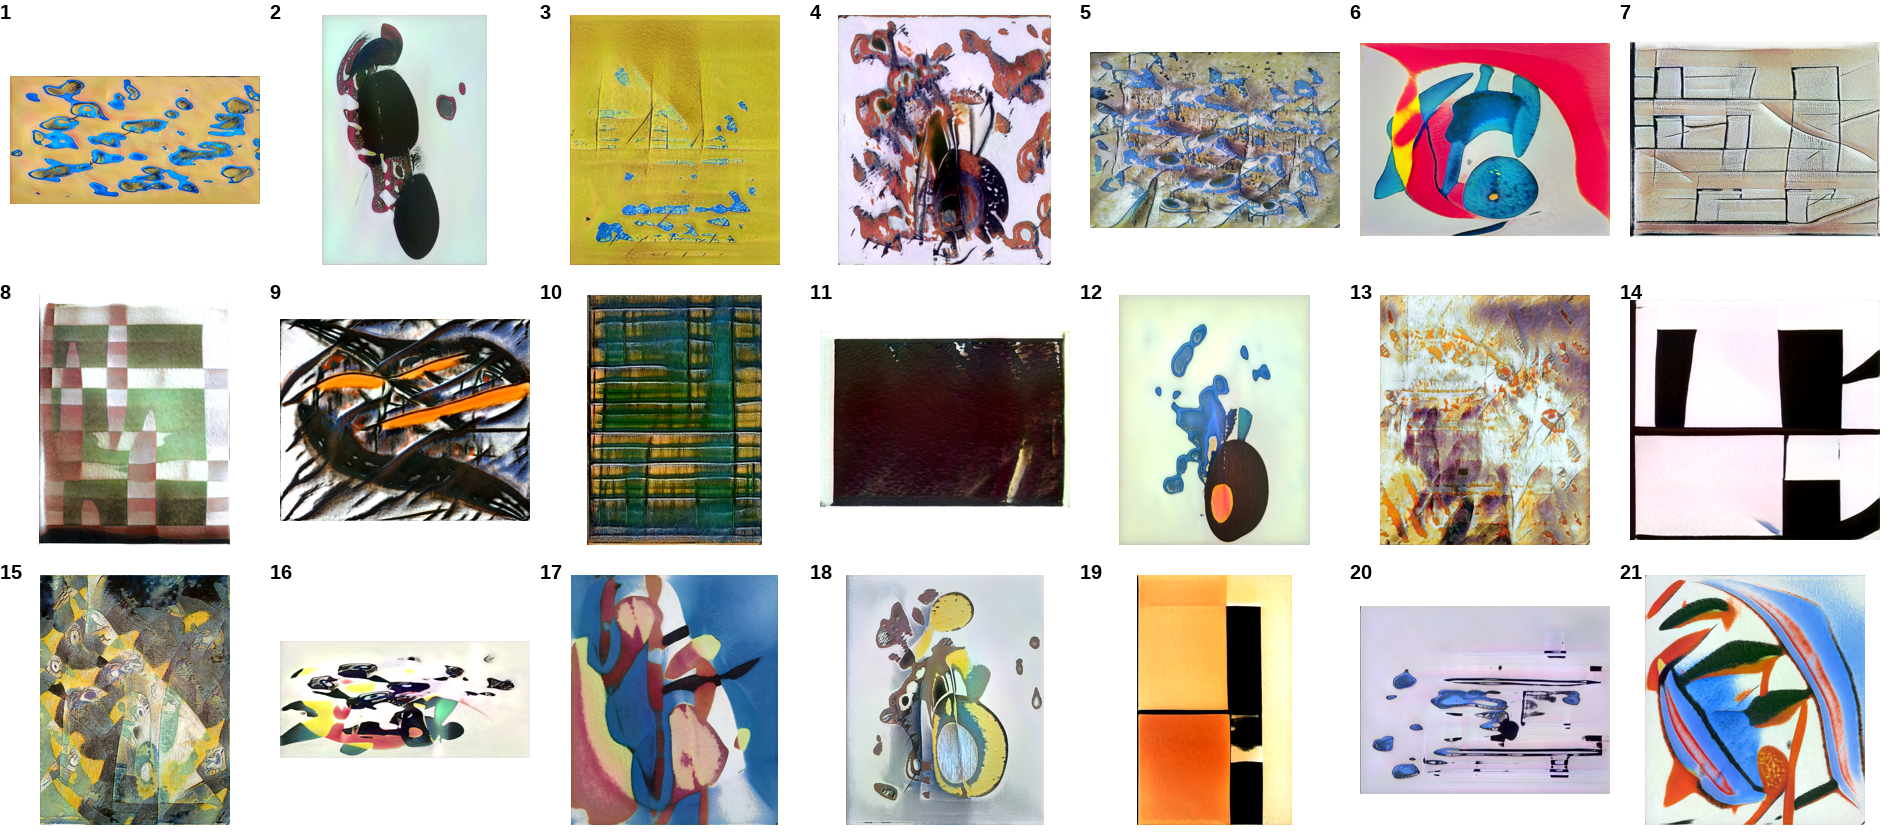

In [10]:
"""

# Show the thumbnails

# NOTE: 1m01s @10:01 on 20220418 Colab GPU T4

%matplotlib inline
group

"""

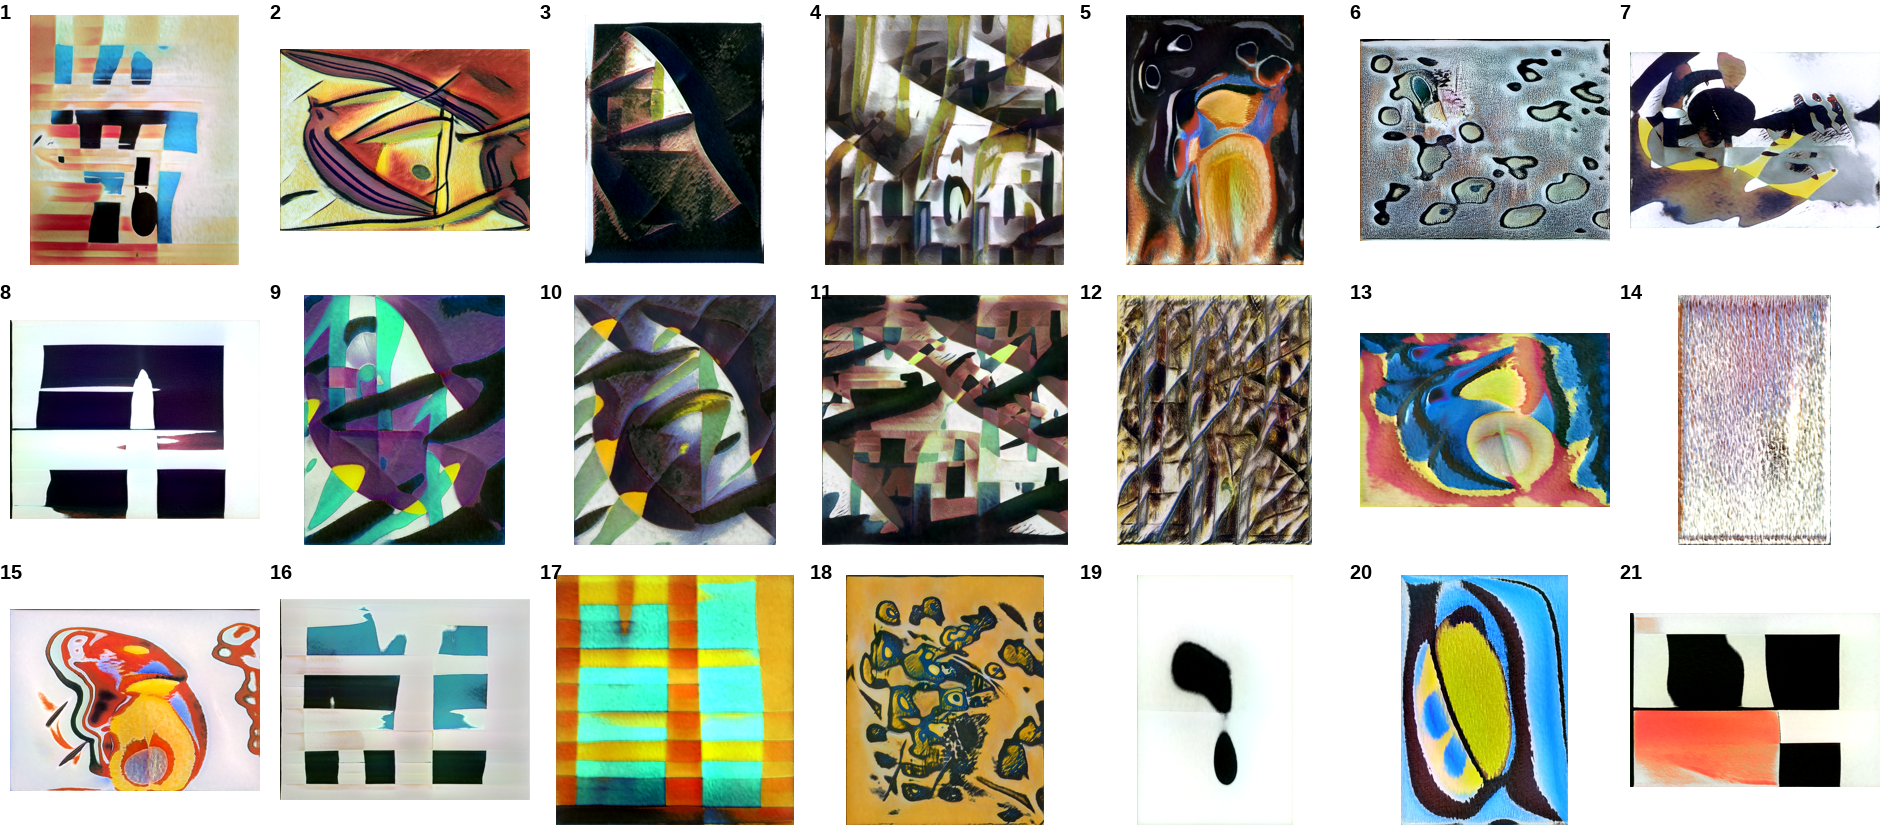

In [10]:
"""
# Show the thumbnails

# NOTE: 1m01s @10:01 on 20220418 Colab GPU T4

%matplotlib inline
group
"""

# **Choose a Painting**
Choose a thumbnail with the slider and hit the Run Cell button to see the full sized image at 1024 pixels wide or tall.

In [19]:
%%time

chosen_thumbnail = 7 #@param {type:"slider", min:1, max:21, step:1}
image = Image.open(image_files[chosen_thumbnail-1])
size = 1024
aspect = aspect_ratios[chosen_thumbnail-1]

if aspect<1:
  newsize = (int(size * aspect), size)
else:
  newsize = (size, int(size / aspect))

resized = image.resize(newsize)
resized

CPU times: user 61.1 ms, sys: 591 µs, total: 61.6 ms
Wall time: 64.1 ms


# **Generate a Super-Resolution Resized Painting (Optional)**
Hit the Run Cell button to generate a Super-Resolution resized painting.

Note that this takes a couple of minutes to run.

In [20]:
%%time

# NOTE: ~2m30s @11:58 on 20220418 Colab Pro T4
#        4m30s @12:33 on 20220418 Colab Pro T4

if inited_ISR == False:
  %tensorflow_version 2.x
  !pip install ISR
  from ISR.models import RDN, RRDN
  from google.colab import files
  model = RRDN(weights='gans')
  inited_ISR = True

npimg = np.array(resized)
row,col,ch= npimg.shape
mean = 0
var = 0.1
sigma = var**0.5
gauss = np.random.normal(mean,sigma,(row,col,ch))*24
gauss = gauss.reshape(row,col,ch)
noisy = np.clip(npimg + gauss, 0, 255).astype('uint8')
noisy_image = Image.fromarray(noisy)
print("Creating the Super-Resolution resized image.")
print("This will take a couple of minutes.")
big_img_np = model.predict(np.array(noisy_image))
big_img = Image.fromarray(big_img_np)
file_name = "big" + str(chosen_thumbnail) + ".jpg"
big_img.resize((big_img.width//2, big_img.height//2))

TensorFlow 2.x selected.
Creating the Super-Resolution resized image.
This will take a couple of minutes.
CPU times: user 7min 4s, sys: 3.92 s, total: 7min 8s
Wall time: 3min 52s


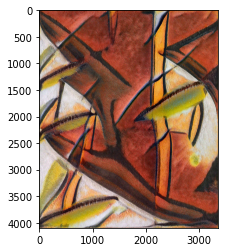

In [21]:
# Small preview

from matplotlib.pyplot import imshow
from matplotlib.axis import Axis
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([1,2,3])

ax.xaxis.zoom(10)
ax.yaxis.zoom(10)

_ = imshow(np.asarray(big_img))

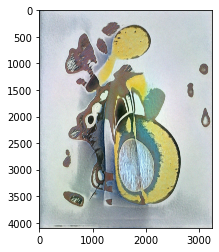

In [13]:
"""
# Small preview

from matplotlib.pyplot import imshow
from matplotlib.axis import Axis
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([1,2,3])

ax.xaxis.zoom(10)
ax.yaxis.zoom(10)

_ = imshow(np.asarray(big_img))
"""

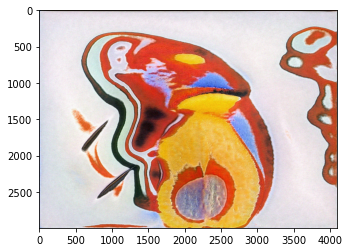

In [14]:
"""
# Small preview

from matplotlib.pyplot import imshow
from matplotlib.axis import Axis
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([1,2,3])

ax.xaxis.zoom(10)
ax.yaxis.zoom(10)

_ = imshow(np.asarray(big_img))
"""

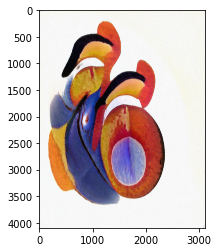

In [11]:
"""
# Small preview

from matplotlib.pyplot import imshow
from matplotlib.axis import Axis
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([1,2,3])

ax.xaxis.zoom(10)
ax.yaxis.zoom(10)

_ = imshow(np.asarray(big_img))
"""

# **Download the High-Res Painting (Optional)**
Hit the Run Cell button to dowload the full-sized painting.

Make sure to enable downloads in your browser.

Image File will appears in your laptop 'Downloads' folder as 'big5.jpg' or 'big5(n).jpg' where n is an integer

In [22]:
# Generate unique datetime stamped filename

dtstamp = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

file_name = f'art_abstract_machineray_{dtstamp}.jpg'

print(f'Downloading into "Downloads" folder with the filename:\n  {file_name}')

  art_abstract_machineray_2022_04_18-05_00_42_PM.jpg


In [23]:
big_img.save(file_name)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>